### Runs our trained U-Net based model on test dataset and save results


Runing on: cpu
Train images: 96 (augmentation: True)
Test images: 24 (augmentation: False)
Model loaded on: cpu

1.4-original_rgb_gray 2020-07-13 22:48:30.853910
	Batch 1: 1/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:48:30.952909
	Batch 2: 2/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:48:33.142986
	Batch 3: 3/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:48:35.202782
	Batch 4: 4/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:48:37.059953
	Batch 5: 5/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:48:38.891878
	Batch 6: 6/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:48:40.747157
	Batch 7: 7/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:48:42.805243
	Batch 8: 8/24 images: torch.Size([1, 1, 256, 448]) m

/home/dalifreire/miniconda3/envs/human_oral_tissues_segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	Batch 22: 22/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:49:18.086104
	Batch 23: 23/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:49:20.225473
	Batch 24: 24/24 images: torch.Size([1, 1, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-07-13 22:49:22.606249


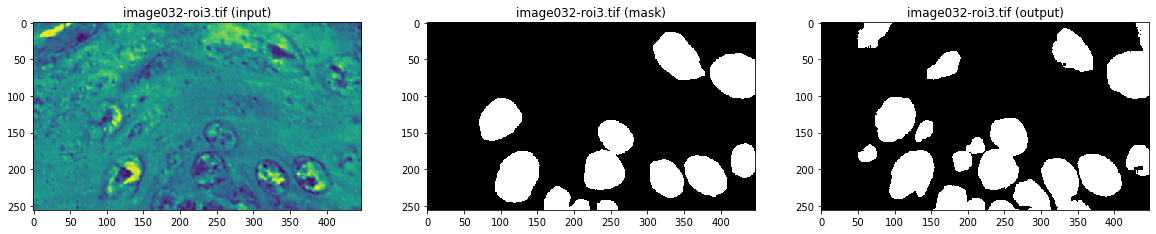

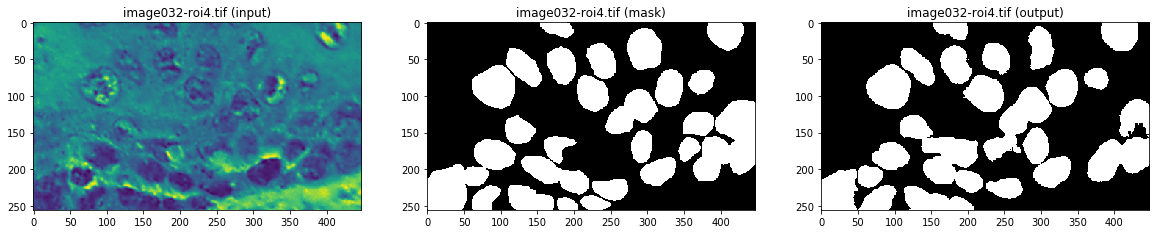

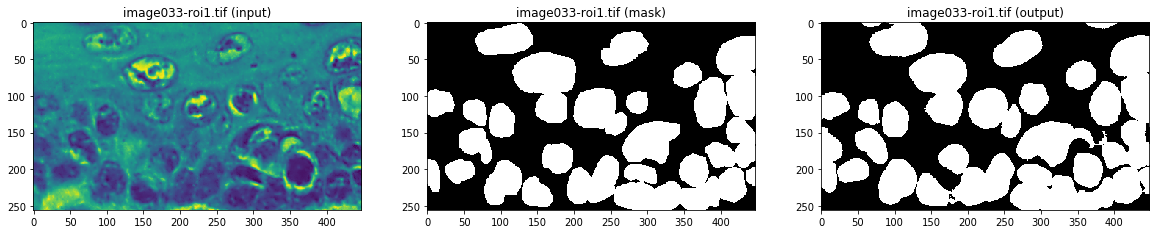

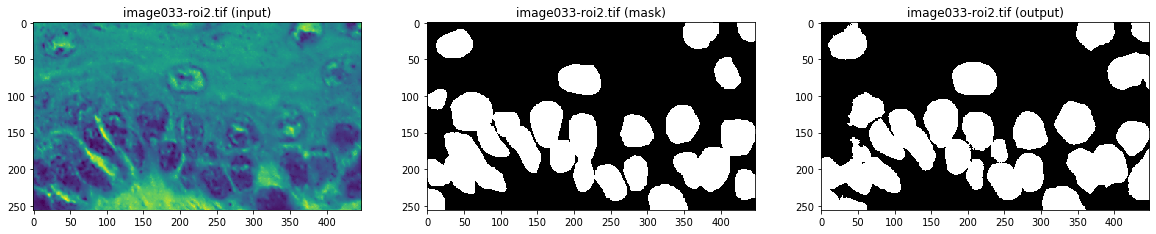

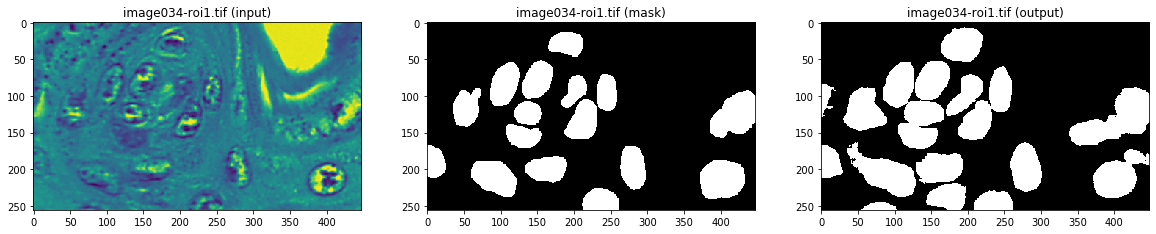

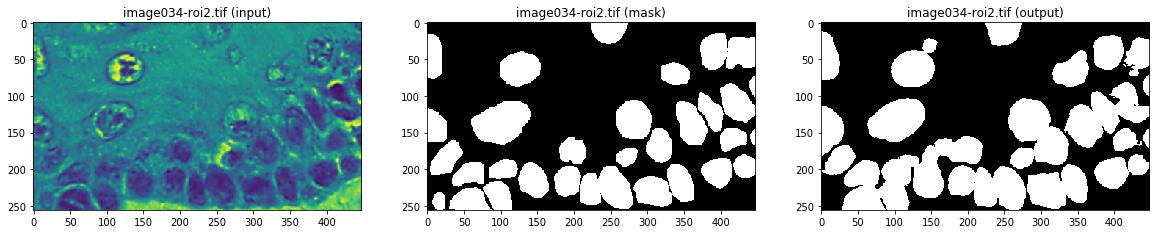

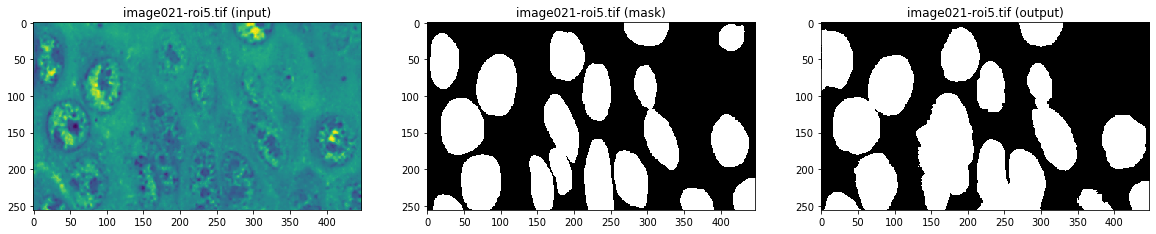

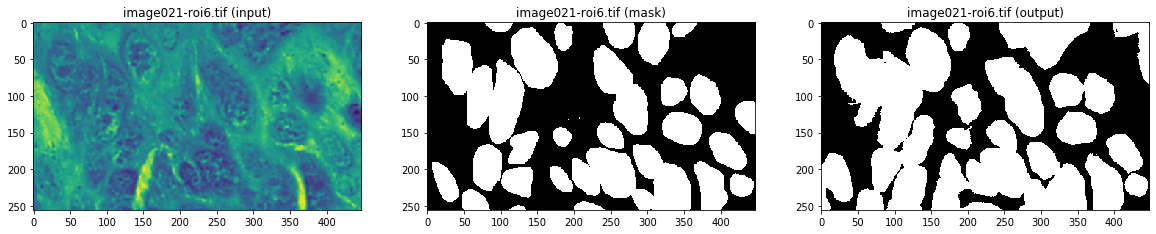

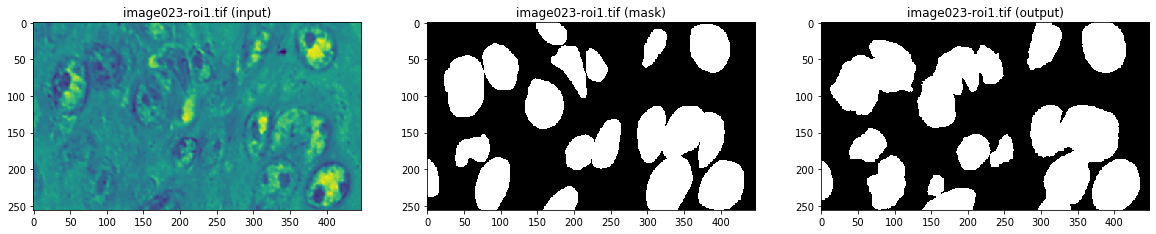

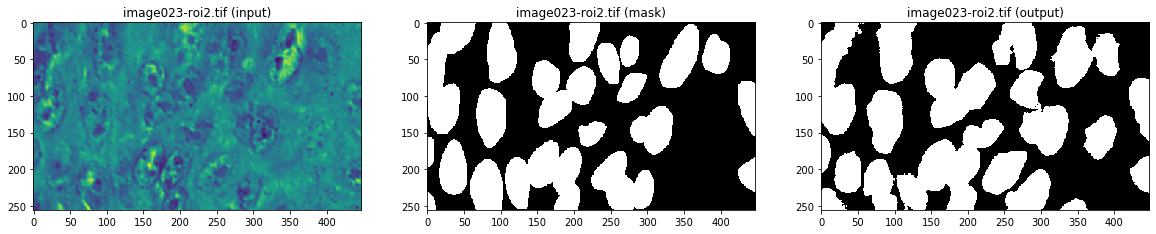

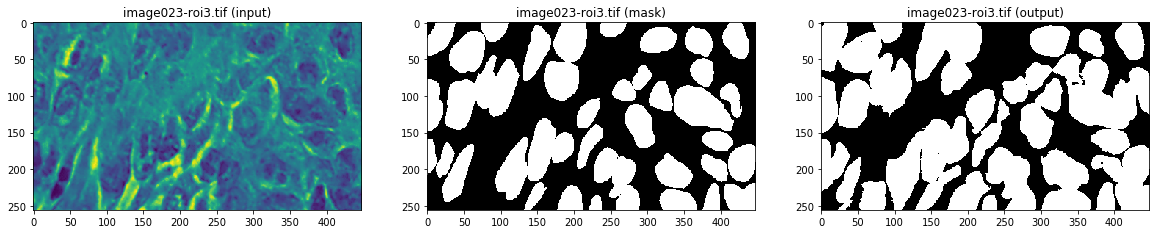

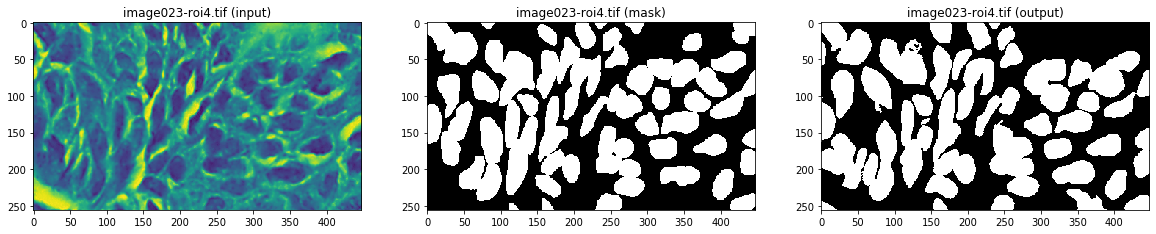

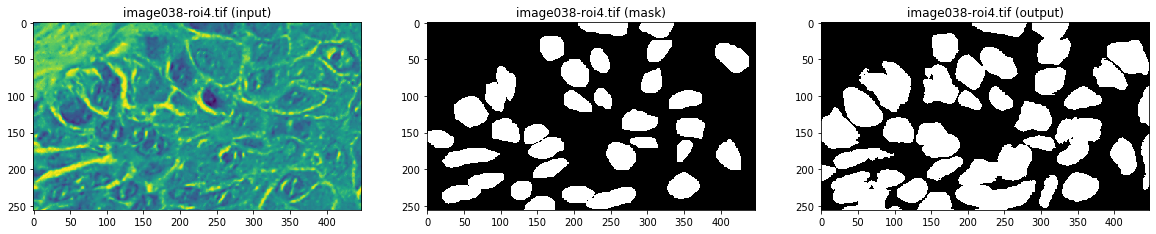

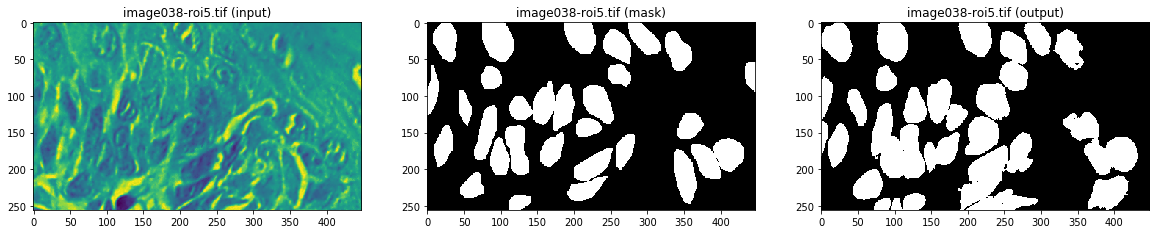

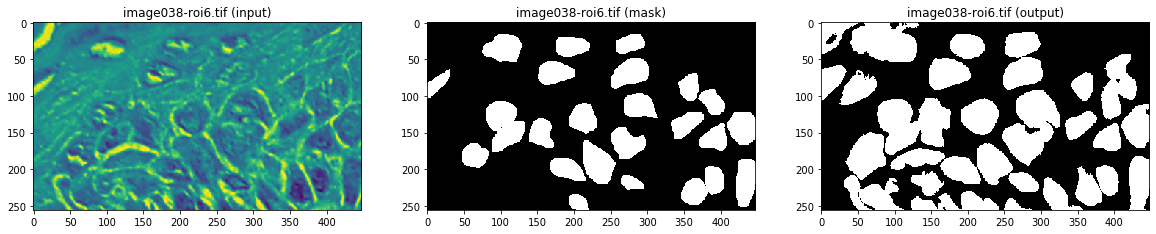

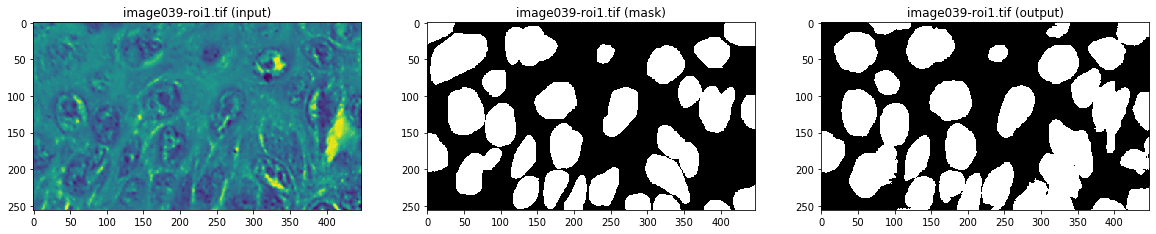

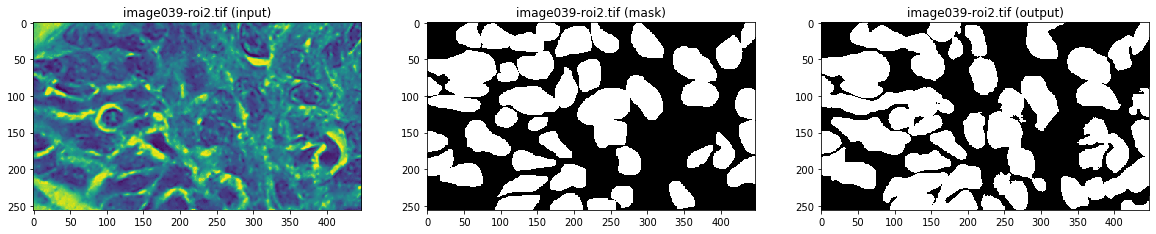

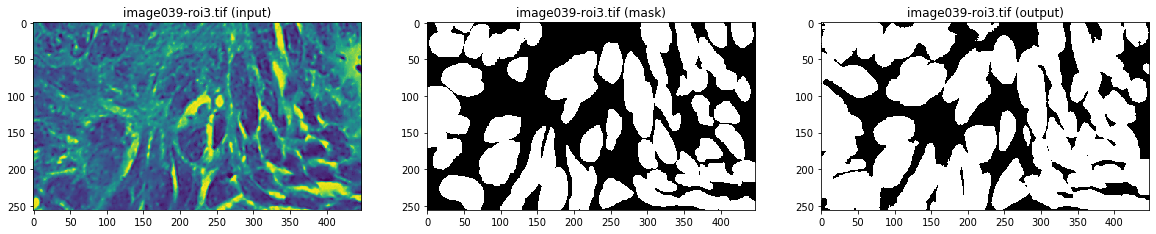

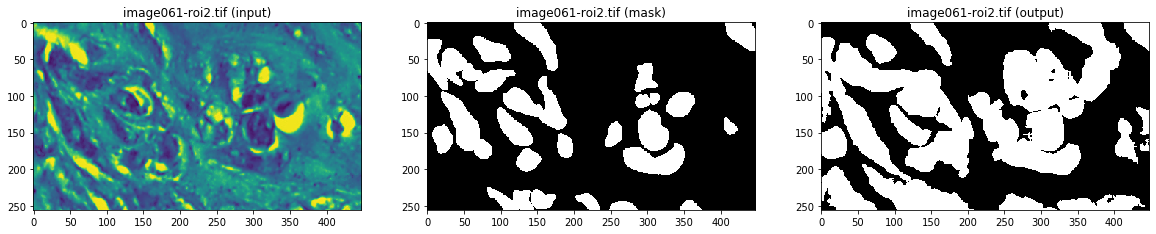

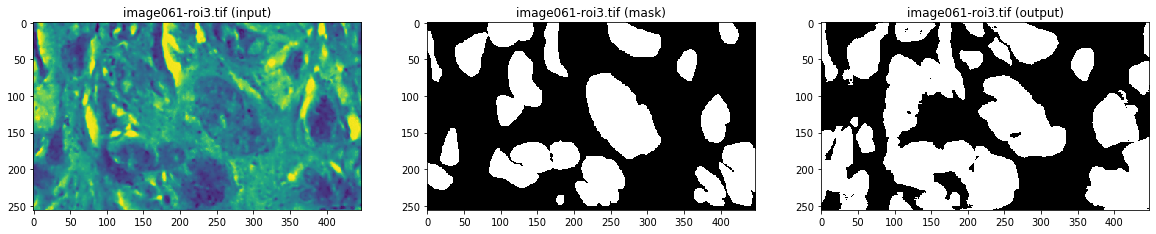

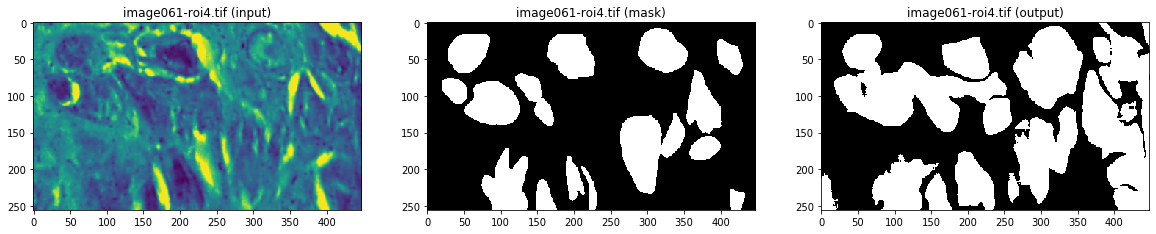

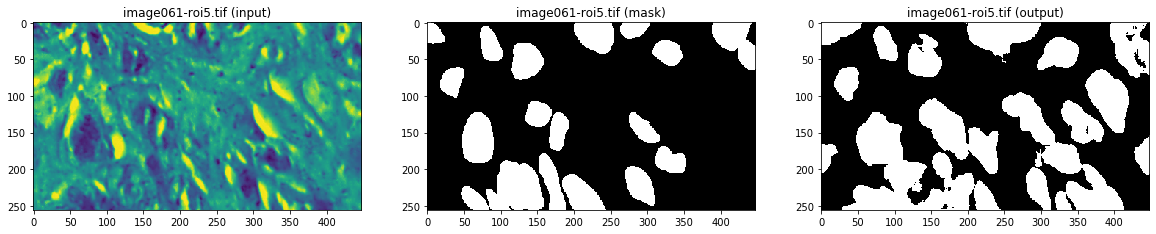

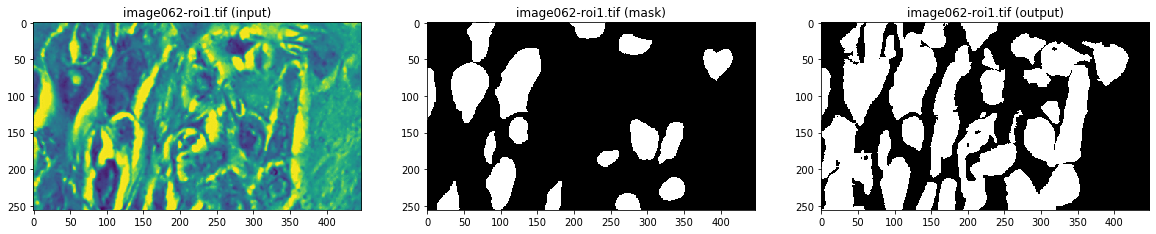

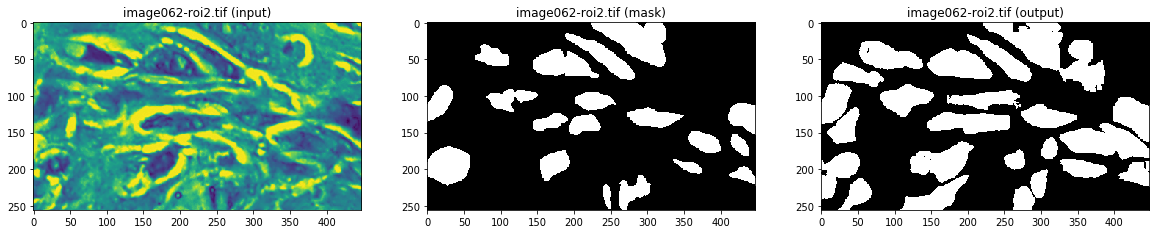

In [3]:
from unet_model import *
from oral_mice_tissues_dataset import *

from torchvision import transforms
from torchvision import utils
from torch.autograd import Variable

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


# Checking for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print()
print('Runing on: {}'.format(device))

color_norm_methods = [
#    "1-original",
    "1.1-original_rgb_r",
    "1.2-original_rgb_g",
    "1.3-original_rgb_b",
    "1.4-original_rgb_gray",    
#    "2-khan_et_al", 
#    "3-macenko_et_al", 
#    "4-tosta_et_al", 
#    "5-reinhard_et_al", 
#    "6-vahadane_et_al",
    "7.0-original_hsv",
    "7.1-original_hsv_h",
    "7.2-original_hsv_s",
    "7.3-original_hsv_v",
    "8.0-original_lab",
    "8.1-original_lab_l",
    "8.2-original_lab_a",
    "8.3-original_lab_b"
]
for color_normalization in color_norm_methods:

    # create the datasets
    batch_size = 1
    color_model = "HSV" if "_hsv" in color_normalization else "LAB" if "_lab" in color_normalization else "RGB"
    dataset_dir = "../histological_oral_mice_tissues/roi"
    method = "1-original" if "-original" in color_normalization else color_normalization
    dataloaders = create_dataloader(method, batch_size, dataset_dir, color_model)


    # directory to save results
    seg_method = "1-unet_based"
    results_dir = "results/{}/{}".format(color_normalization, seg_method)
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)


    # load the trained model
    epoch = 500
    in_channels = 1 if any(x in color_normalization for x in ['rgb_r', 'rgb_g', 'rgb_b', 'hsv_h', 'hsv_s', 'hsv_v', 'lab_l', 'lab_a', 'lab_b']) else 3
    model = UNet(in_channels=in_channels, out_channels=1, padding=True).to(device)
    model = load_checkpoint(file_path="{}__Dataset-{}__Epoch-{}__Size-448x256.pt".format(model.name(), color_normalization, epoch))
    print("")

    # iterate over test dataset images        
    t1 = datetime.now()
    print("{} {}".format(color_normalization, t1))
    for batch_idx, (images, masks, fname, original_size) in enumerate(dataloaders['test']):

        t = datetime.now()

        X = Variable(images.to(device))
        if 'rgb_r' in color_normalization:
            X = X[:, 0, :, :].unsqueeze(1) # 'r' channel from rgb
        elif 'rgb_g' in color_normalization:
            X = X[:, 1, :, :].unsqueeze(1) # 'g' channel from rgb
        elif 'rgb_b' in color_normalization:
            X = X[:, 2, :, :].unsqueeze(1) # 'b' channel from rgb
        
        elif "hsv_h" in color_normalization:
            X = X[:, 0, :, :].unsqueeze(1) # 'h' channel from hsv
        elif "hsv_s" in color_normalization:
            X = X[:, 1, :, :].unsqueeze(1) # 's' channel from hsv
        elif "hsv_v" in color_normalization:
            X = X[:, 2, :, :].unsqueeze(1) # 'v' channel from hsv
            
        elif "lab_l" in color_normalization:
            X = X[:, 0, :, :].unsqueeze(1) # 'l' channel from lab
        elif "lab_a" in color_normalization:
            X = X[:, 1, :, :].unsqueeze(1) # 'a' channel from lab
        elif "lab_b" in color_normalization:
            X = X[:, 2, :, :].unsqueeze(1) # 'b' channel from lab
        
        
        print('\tBatch {}: {}/{} images: {} masks: {} {}'.format(
            (batch_idx+1), 
            (batch_idx+1) * len(images), 
            len(dataloaders['test'].dataset),
            images.shape,
            masks.shape,
            datetime.now()))


        y_hat = model(X).squeeze(0)
        X_numpy = X.cpu().numpy()
        y_hat_numpy = y_hat.detach().cpu().numpy()


        input_image_filename  = '{}/{} - input.png'.format(results_dir, fname[0][0:-4])
        mask_image_filename   = '{}/{} - mask.png'.format(results_dir, fname[0][0:-4])
        output_image_filename = '{}/{} - output - 1.png'.format(results_dir, fname[0][0:-4])
        output_image_filename_otsu  = '{}/{} - output - 2 - otsu.png'.format(results_dir, fname[0][0:-4])
        output_image_filename_hyst  = '{}/{} - output - 3 - hysteresis.png'.format(results_dir, fname[0][0:-4])
        output_image_filename_basic = '{}/{} - output - 4 - basic.png'.format(results_dir, fname[0][0:-4])
        f, ax = plt.subplots(1, 3, figsize=(20, 20))


        # save the input image
        input_image = images[0]
        utils.save_image(input_image, input_image_filename)
        ax[0].imshow(input_image.permute(1, 2, 0))
        ax[0].set_title('{} (input)'.format(fname[0]))

        # save the mask image
        mask_image = masks[0]
        utils.save_image(mask_image, mask_image_filename)
        ax[1].imshow(mask_image, cmap='gray')
        ax[1].set_title('{} (mask)'.format(fname[0]))

        # save the predicted output image
        output_image = y_hat[0].squeeze(0).detach().cpu().numpy()
        output_image_otsu  = otsu_threshold(np_img=output_image)
        output_image_hyst  = hysteresis_threshold(np_img=output_image, low=0.2, high=0.8)
        output_image_basic = basic_threshold(np_img=output_image, threshold=0.2)

        utils.save_image(y_hat[0], output_image_filename)
        utils.save_image(TF.to_tensor(np_to_pil(output_image_otsu)), output_image_filename_otsu)
        utils.save_image(TF.to_tensor(np_to_pil(output_image_hyst)), output_image_filename_hyst)
        utils.save_image(TF.to_tensor(np_to_pil(output_image_basic)), output_image_filename_basic)

        ax[2].imshow(output_image_hyst, cmap='gray')
        ax[2].set_title('{} (output)'.format(fname[0]))
        

### Qualitative analysis

### Qualitative analysis

In [4]:
from torchvision import utils
from torchvision import transforms
from image_utils import *
from experimental_evaluation import *

import os
import csv
import collections

color_norm_methods = [
#    "1-original",
    "1.1-original_rgb_r",
    "1.2-original_rgb_g",
    "1.3-original_rgb_b",
    "1.4-original_rgb_gray",    
#    "2-khan_et_al", 
#    "3-macenko_et_al", 
#    "4-tosta_et_al", 
#    "5-reinhard_et_al", 
#    "6-vahadane_et_al",
    "7.0-original_hsv",
    "7.1-original_hsv_h",
    "7.2-original_hsv_s",
    "7.3-original_hsv_v",
    "8.0-original_lab",
    "8.1-original_lab_l",
    "8.2-original_lab_a",
    "8.3-original_lab_b"
]
seg_methods = [
    "1-unet_based"
    #"2-de_oliveira_et_al_(2013)", 
    #"3-phoulady_et_al_(2016)", 
    #"4-vahadane_and_sethi_(2013)", 
    #"5-wienert_et_al_(2012)"
]
results_dir = "../dysplastic_oral_tissues_segmentation/results"

for r, d, f in sorted(os.walk(results_dir)):
    for norm_method in sorted(color_norm_methods):
        if (r.endswith(norm_method)):
            
            print(r)
            for seg_method in sorted(seg_methods):
                
                print("\t{}".format(seg_method))
                seg_method_dir = "{}/{}".format(r, seg_method)
                
                for r_seg, d_seg, f_sef in sorted(os.walk(seg_method_dir)):
                    for file in sorted(f_sef):
                        
                        threshold_type = "output - 2 - otsu.png" if seg_method == "1-unet_based" else "output.png"
                        if file.lower().endswith(threshold_type):
                            
                            input_filename = "{}/{}/{}".format(r, "1-unet_based", file.replace(threshold_type, 'input.png'))
                            mask_filename = "{}/{}/{}".format(r, "1-unet_based", file.replace(threshold_type, 'mask.png'))
                            output_filename = "{}/{}/{}".format(r, seg_method, file)

                            input_image = load_pil_image(input_filename)
                            mask_image = load_pil_image(mask_filename, gray=True)
                            output_image = load_pil_image(output_filename, gray=True)

                            
                            merge_image_output_b = cut_image_by_mask(input_image, output_image, inverse=True)
                            merge_image_mask_b = cut_image_by_mask(input_image, mask_image, inverse=True)

                            merge_image_output_f = cut_image_by_mask(input_image, output_image, inverse=False)
                            merge_image_mask_f = cut_image_by_mask(input_image, mask_image, inverse=False)

                                                        
                            utils.save_image(transforms.ToTensor()(merge_image_output_f), output_filename.replace(".png", "_2.png"))
                            utils.save_image(transforms.ToTensor()(merge_image_mask_f), output_filename.replace(".png", "_3.png"))
                            
                            utils.save_image(transforms.ToTensor()(merge_image_output_b), output_filename.replace(".png", "_4.png"))
                            utils.save_image(transforms.ToTensor()(merge_image_mask_b), output_filename.replace(".png", "_5.png"))


../dysplastic_oral_tissues_segmentation/results/1.1-original_rgb_r
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/1.2-original_rgb_g
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/1.3-original_rgb_b
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/1.4-original_rgb_gray
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/7.0-original_hsv
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/7.1-original_hsv_h
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/7.2-original_hsv_s
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/7.3-original_hsv_v
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/8.0-original_lab
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/8.1-original_lab_l
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/8.2-original_lab_a
	1-unet_based
../dysplastic_oral_tissues_segmentation/results/8.3-original_lab_b
	1-unet_based


### Quantitative analysis

In [5]:
from torchvision import utils
from image_utils import *
from experimental_evaluation import *

import os
import csv
import collections


color_norm_methods = [
#    "1-original",
    "1.1-original_rgb_r",
    "1.2-original_rgb_g",
    "1.3-original_rgb_b",
    "1.4-original_rgb_gray",    
#    "2-khan_et_al", 
#    "3-macenko_et_al", 
#    "4-tosta_et_al", 
#    "5-reinhard_et_al", 
#    "6-vahadane_et_al",
    "7.0-original_hsv",
    "7.1-original_hsv_h",
    "7.2-original_hsv_s",
    "7.3-original_hsv_v",
    "8.0-original_lab",
    "8.1-original_lab_l",
    "8.2-original_lab_a",
    "8.3-original_lab_b"
]
seg_methods = [
    "1-unet_based"
    #"2-de_oliveira_et_al_(2013)", 
    #"3-phoulady_et_al_(2016)", 
    #"4-vahadane_and_sethi_(2013)", 
    #"5-wienert_et_al_(2012)"
]
results_dir = "../dysplastic_oral_tissues_segmentation/results"

for r, d, f in sorted(os.walk(results_dir)):
    for norm_method in sorted(color_norm_methods):
        if (r.endswith(norm_method)):
            
            print(r)
            for seg_method in sorted(seg_methods):
                
                print("\t{}".format(seg_method))
                seg_method_dir = "{}/{}".format(r, seg_method)
                
                if os.path.exists(seg_method_dir):
                    with open('{}/quantitative_analysis.csv'.format(seg_method_dir), mode='w') as medidas_file:
                        medidas_writer = csv.writer(medidas_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                        medidas_writer.writerow(['image', 'accuracy', 'precision', 'f1/dice', 'jaccard', 'sensitivity/recall', 'specificity'])

                        for r_seg, d_seg, f_sef in sorted(os.walk(seg_method_dir)):
                            for file in sorted(f_sef):

                                threshold_type = "output - 2 - otsu.png" if seg_method == "1-unet_based" else "output.png"
                                if file.lower().endswith(threshold_type):

                                    mask_filename = "{}/{}/{}".format(r, "1-unet_based", file.replace(threshold_type, "mask.png"))
                                    output_filename = "{}/{}/{}".format(r, seg_method, file)

                                    accuracy = pixel_accuracy_score(mask_filename, output_filename)
                                    jaccard = jaccard_index_score(mask_filename, output_filename)
                                    precision = precision_score(mask_filename, output_filename)
                                    recall = recall_score(mask_filename, output_filename)
                                    f1 = f1_score(mask_filename, output_filename)
                                    sensitivity = sensitivity_score(mask_filename, output_filename)
                                    specificity = specificity_score(mask_filename, output_filename)
                                    dice = dice_score(mask_filename, output_filename)

                                    print(file.replace(" - " + threshold_type, ""))
                                    print('\t{}: \t\t{}'.format('accuracy', accuracy))
                                    print('\t{}: \t\t{}'.format('precision', precision))
                                    print('\t{}: \t\t{}'.format('f1/dice', f1))
                                    print('\t{}: \t\t{}'.format('jaccard', jaccard))
                                    print('\t{}: \t{}'.format('sensitivity/recall', sensitivity))
                                    print('\t{}: \t\t{}'.format('specificity', specificity))
                                    print()

                                    medidas_writer.writerow([file.replace(" - " + threshold_type, ""), accuracy, precision, f1, jaccard, sensitivity, specificity])

../dysplastic_oral_tissues_segmentation/results/1.1-original_rgb_r
	1-unet_based
image021-roi5
	accuracy: 		0.935791015625
	precision: 		0.9124603867174942
	f1/dice: 		0.9151925557398195
	jaccard: 		0.8436451653998046
	sensitivity/recall: 	0.9179411357020746
	specificity: 		0.9466121397159744

image021-roi6
	accuracy: 		0.887939453125
	precision: 		0.8858295198945164
	f1/dice: 		0.8766839378238342
	jaccard: 		0.7804428044280443
	sensitivity/recall: 	0.8677252697158486
	specificity: 		0.9050934880722115

image023-roi1
	accuracy: 		0.9206194196428571
	precision: 		0.8786902586787191
	f1/dice: 		0.8892511313318088
	jaccard: 		0.8005870241380821
	sensitivity/recall: 	0.9000689519306541
	specificity: 		0.9318844492440604

image023-roi2
	accuracy: 		0.8726545061383929
	precision: 		0.8646494009866103
	f1/dice: 		0.8431745213628409
	jaccard: 		0.7288692520467076
	sensitivity/recall: 	0.8227405125626035
	specificity: 		0.9082234533426912

image023-roi3
	accuracy: 		0.8519374302455357
	precisio

image038-roi6
	accuracy: 		0.8448660714285714
	precision: 		0.6254319098989792
	f1/dice: 		0.7271835132482827
	jaccard: 		0.5713184271395528
	sensitivity/recall: 	0.8684759916492694
	specificity: 		0.8374892716141215

image039-roi1
	accuracy: 		0.88079833984375
	precision: 		0.8982676181551695
	f1/dice: 		0.8454223719767979
	jaccard: 		0.7322351927295518
	sensitivity/recall: 	0.7984494468412284
	specificity: 		0.9376123537559308

image039-roi2
	accuracy: 		0.8398263113839286
	precision: 		0.8877543964782078
	f1/dice: 		0.8074504213659804
	jaccard: 		0.6770791217677149
	sensitivity/recall: 	0.7404694619066844
	specificity: 		0.9222926074260822

image039-roi3
	accuracy: 		0.8152117047991071
	precision: 		0.8954249628242019
	f1/dice: 		0.8139741057713408
	jaccard: 		0.6863038233247976
	sensitivity/recall: 	0.7461058187435633
	specificity: 		0.8969435140073082

image061-roi2
	accuracy: 		0.8273838588169643
	precision: 		0.6175545661176324
	f1/dice: 		0.6670814764987807
	jaccard: 		0.500466

image023-roi2
	accuracy: 		0.8677106584821429
	precision: 		0.8577520828295707
	f1/dice: 		0.8372312577779686
	jaccard: 		0.7200324771183939
	sensitivity/recall: 	0.8176693698790889
	specificity: 		0.9033703167231621

image023-roi3
	accuracy: 		0.8476649693080357
	precision: 		0.8350464464354422
	f1/dice: 		0.839159294072158
	jaccard: 		0.7228892730819865
	sensitivity/recall: 	0.8433128561912516
	specificity: 		0.8515434338104346

image023-roi4
	accuracy: 		0.83441162109375
	precision: 		0.8982093204315427
	f1/dice: 		0.8096121264373578
	jaccard: 		0.6801246420751221
	sensitivity/recall: 	0.7369237507756323
	specificity: 		0.923598357097539

image032-roi3
	accuracy: 		0.9167829241071429
	precision: 		0.7688726821320506
	f1/dice: 		0.805953155497723
	jaccard: 		0.6749761612859283
	sensitivity/recall: 	0.8467914210031616
	specificity: 		0.9347297386122128

image032-roi4
	accuracy: 		0.8850010463169643
	precision: 		0.9259052613959716
	f1/dice: 		0.8342444922017369
	jaccard: 		0.715625606

image039-roi3
	accuracy: 		0.8543439592633929
	precision: 		0.8794868796873173
	f1/dice: 		0.8630883594371093
	jaccard: 		0.7591516602027134
	sensitivity/recall: 	0.8472901647785788
	specificity: 		0.8626865103532277

image061-roi2
	accuracy: 		0.8312203543526786
	precision: 		0.6081413917232793
	f1/dice: 		0.6989345983357959
	jaccard: 		0.5372017405441591
	sensitivity/recall: 	0.8215957291209595
	specificity: 		0.8342340279367987

image061-roi3
	accuracy: 		0.9151175362723214
	precision: 		0.8536659490945929
	f1/dice: 		0.8738156035723081
	jaccard: 		0.7759081073615395
	sensitivity/recall: 	0.8949394647408666
	specificity: 		0.9249844204403822

image061-roi4
	accuracy: 		0.8504115513392857
	precision: 		0.6901581914718923
	f1/dice: 		0.746175469744045
	jaccard: 		0.5951195336653058
	sensitivity/recall: 	0.8120893984284426
	specificity: 		0.8646396288679516

image061-roi5
	accuracy: 		0.8571428571428571
	precision: 		0.6524107142857143
	f1/dice: 		0.7279580247733537
	jaccard: 		0.57227

image032-roi4
	accuracy: 		0.85784912109375
	precision: 		0.897115050399722
	f1/dice: 		0.79164696410086
	jaccard: 		0.6551454257006875
	sensitivity/recall: 	0.7083685931889394
	specificity: 		0.9499471570492496

image033-roi1
	accuracy: 		0.84259033203125
	precision: 		0.8985360464045667
	f1/dice: 		0.8121924577373212
	jaccard: 		0.6837744574261241
	sensitivity/recall: 	0.7409882120688673
	specificity: 		0.9289112519554243

image033-roi2
	accuracy: 		0.8735264369419643
	precision: 		0.8463914780292943
	f1/dice: 		0.8142028205817932
	jaccard: 		0.6866290751182837
	sensitivity/recall: 	0.7843727633949505
	specificity: 		0.9222316601275465

image034-roi1
	accuracy: 		0.9230695452008929
	precision: 		0.799755272439358
	f1/dice: 		0.8343627386562036
	jaccard: 		0.7157996456756321
	sensitivity/recall: 	0.8721007809740591
	specificity: 		0.9376282130326096

image034-roi2
	accuracy: 		0.9047938755580357
	precision: 		0.860457906033866
	f1/dice: 		0.8685677142891534
	jaccard: 		0.7676709647219

image061-roi5
	accuracy: 		0.8503156389508929
	precision: 		0.6542613914348152
	f1/dice: 		0.700322946670158
	jaccard: 		0.5388438188362972
	sensitivity/recall: 	0.7533613760985503
	specificity: 		0.8796302604982853

image062-roi1
	accuracy: 		0.7916957310267857
	precision: 		0.4660263338901444
	f1/dice: 		0.6136304825980075
	jaccard: 		0.442616831151863
	sensitivity/recall: 	0.8980780155273622
	specificity: 		0.7676777393014407

image062-roi2
	accuracy: 		0.8282906668526786
	precision: 		0.5563219074233731
	f1/dice: 		0.6552285579229329
	jaccard: 		0.4872415768369526
	sensitivity/recall: 	0.7969082701643813
	specificity: 		0.8363704142271342

../dysplastic_oral_tissues_segmentation/results/8.0-original_lab
	1-unet_based
image021-roi5
	accuracy: 		0.91888427734375
	precision: 		0.9440945087687201
	f1/dice: 		0.8859185500386281
	jaccard: 		0.795200880572372
	sensitivity/recall: 	0.8344961419396572
	specificity: 		0.9700428559424106

image021-roi6
	accuracy: 		0.8615635463169643
	precisi

image034-roi2
	accuracy: 		0.9035906110491071
	precision: 		0.8677045654511683
	f1/dice: 		0.8652620547628042
	jaccard: 		0.7625214776632302
	sensitivity/recall: 	0.8628332563734902
	specificity: 		0.9263948001794917

image038-roi4
	accuracy: 		0.8781476702008929
	precision: 		0.7113064008394544
	f1/dice: 		0.7951029983139066
	jaccard: 		0.6598929179849111
	sensitivity/recall: 	0.9012797074954296
	specificity: 		0.869921870382847

image038-roi5
	accuracy: 		0.8633248465401786
	precision: 		0.752725087975281
	f1/dice: 		0.7704810015374477
	jaccard: 		0.6266523758485173
	sensitivity/recall: 	0.7890948353428109
	specificity: 		0.8937501536645932

image038-roi6
	accuracy: 		0.8451974051339286
	precision: 		0.6208153040309724
	f1/dice: 		0.7343090598904551
	jaccard: 		0.5801645856980704
	sensitivity/recall: 	0.8985825733435886
	specificity: 		0.8285174801167249

image039-roi1
	accuracy: 		0.8875906808035714
	precision: 		0.8733330399190177
	f1/dice: 		0.8602705280499435
	jaccard: 		0.754802

image021-roi6
	accuracy: 		0.8079746791294643
	precision: 		0.7701617883166605
	f1/dice: 		0.7985584530811237
	jaccard: 		0.6646669204415683
	sensitivity/recall: 	0.8291293116547637
	specificity: 		0.7900225660863959

image023-roi1
	accuracy: 		0.8544747488839286
	precision: 		0.8592801778525506
	f1/dice: 		0.7741359244322947
	jaccard: 		0.6315022520533428
	sensitivity/recall: 	0.7043439716312057
	specificity: 		0.9367710583153348

image023-roi2
	accuracy: 		0.8316301618303571
	precision: 		0.8101163577619142
	f1/dice: 		0.7935377640920367
	jaccard: 		0.6577394140271894
	sensitivity/recall: 	0.7776241067873683
	specificity: 		0.8701151313333433

image023-roi3
	accuracy: 		0.8024640764508929
	precision: 		0.8230716976471315
	f1/dice: 		0.7792405211307407
	jaccard: 		0.6383243666086623
	sensitivity/recall: 	0.7398416105395603
	specificity: 		0.8582712222148935

image023-roi4
	accuracy: 		0.810302734375
	precision: 		0.8992411059551431
	f1/dice: 		0.7737756056982428
	jaccard: 		0.63102284

In [7]:
target = "/mnt/DADOS/PhD/github/dysplastic_oral_tissues_segmentation/results/7-original_hsv/5-wienert_et_al_(2012)/image023-roi1 - mask.png"
prediction = "/mnt/DADOS/PhD/github/dysplastic_oral_tissues_segmentation/results/7-original_hsv/5-wienert_et_al_(2012)/image023-roi1 - output.png"


mask_np = image_path_to_np(target)
output_np = image_path_to_np(prediction).copy()
if np.unique(output_np).size:
    output_np[output_np > 0] = 255
print(np.unique(mask_np))
print(np.unique(output_np).size)

jaccard = metrics.jaccard_score(mask_np, output_np, average='micro')
print(jaccard)

[  0 255]
2
0.0681091113336101
